<a href="https://colab.research.google.com/github/amoghgadagi/Kaggle_Notebooks/blob/main/Assignment_CNN_Skin_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Getting the data from Kaggle

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
## Mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab Notebooks'

In [6]:
!kaggle datasets download -d jaiahuja/skin-cancer-detection

 99% 775M/786M [00:03<00:00, 254MB/s]
100% 786M/786M [00:03<00:00, 260MB/s]


In [7]:
!unzip \*.zip && rm*.zip

Archive:  skin-cancer-detection.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin cancer ISI

### Importing all the libraries, creating and visualizing the dataset


> We will use image_dataset_from_directory utility to import dataset and split 0.2 to validation dataset

> We will use matplotlib lib to plot images of each class





In [8]:
import os
import shutil
import numpy as np
import glob   
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Input, Add,Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import  plot_model
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [9]:
# Defining the path for train and test images

import pathlib
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [10]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [11]:
batch_size = 32
img_height = 180
img_width = 180


train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, seed=123, subset='training',
                                                                 image_size=(img_height, img_width), validation_split=0.2,
                                                                  batch_size= batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, seed=123, subset='validation',
                                                                 image_size=(img_height, img_width), validation_split=0.2,
                                                                 batch_size= batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test, seed=123,
                                                                 image_size=(img_height, img_width),
                                                                 batch_size= batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Found 118 files belonging to 9 classes.


In [12]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


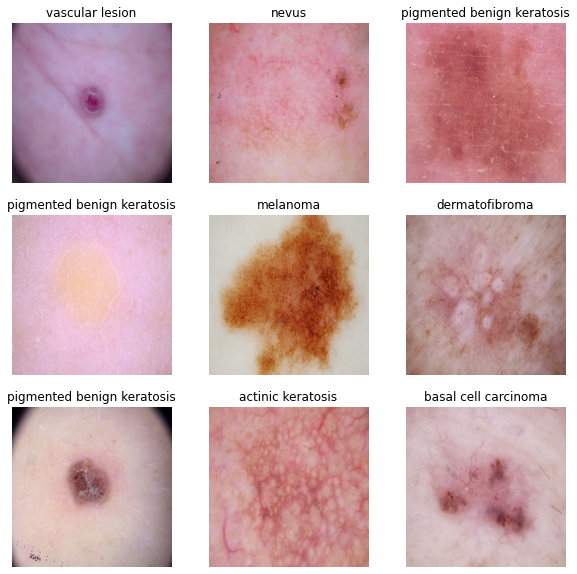

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Brief contents of the notebook:

### Model-1 building


> Lets build a baseline model to check out how we can improve the model.


In [16]:
num_classes = len(class_names)

model_1 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(50, 1, activation='relu'),
  # tf.keras.layers.Dropout(0.1),
  tf.keras.layers.MaxPooling2D(4),
  tf.keras.layers.Conv2D(50, 1, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.MaxPooling2D(4),
  tf.keras.layers.Flatten(),
  # tf.keras.layers.Dense(50, activation='relu'),
  # tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [17]:
model_1.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [18]:
epochs=20
history_1 = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 22s 193ms/step - loss: 1.9879 - accuracy: 0.2494 - val_loss: 1.9066 - val_accuracy: 0.2975
Epoch 2/20
56/56 [==============================] - 2s 32ms/step - loss: 1.7889 - accuracy: 0.3588 - val_loss: 1.7405 - val_accuracy: 0.3691
Epoch 3/20
56/56 [==============================] - 2s 32ms/step - loss: 1.6121 - accuracy: 0.4286 - val_loss: 1.6096 - val_accuracy: 0.4430
Epoch 4/20
56/56 [==============================] - 2s 32ms/step - loss: 1.4990 - accuracy: 0.4732 - val_loss: 1.5356 - val_accuracy: 0.4653
Epoch 5/20
56/56 [==============================] - 2s 32ms/step - loss: 1.4211 - accuracy: 0.5056 - val_loss: 1.4669 - val_accuracy: 0.4832
Epoch 6/20
56/56 [==============================] - 2s 32ms/step - loss: 1.3664 - accuracy: 0.5184 - val_loss: 1.4266 - val_accuracy: 0.5034
Epoch 7/20
56/56 [==============================] - 2s 32ms/step - loss: 1.3241 - accuracy: 0.5363 - val_loss: 1.3983 - val_accuracy: 0.5078
Epoch 8/20
56/56 [====

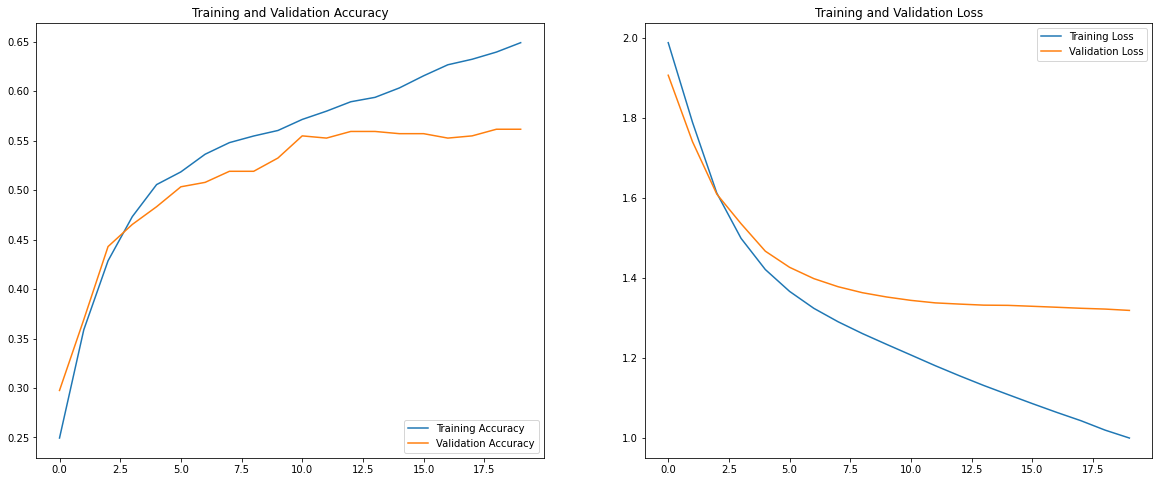

In [19]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Inference


> Model doesn't do good on the data

> It also overfits as the training accuracy is almost 10 percent higher than validation accuracy.



> This clearly call for more data.

> Since we don't have data available, we can use different techniques such as Image augmentation and generation from the libraries available through tensorflow



> Could have increased the model complexity hence increasing the training accuracy, but it would overfit by a largin margin i.e. more than 30%



> Chose a simple model to have the validation accuracy within 10% of the training accuracy.

> We can also increase accuracy by using pretrained model from tensorflow hub (Transfer learning). We will explore this section later in the notebook.















### Model 2

> More convolutional layers i.e. more learning


> Changing optimizer from adam to sgd


> More epochs to allow us to train the model better resulting in higher/lower accuracy depending on model complexity and dataset



> Also increasing the learning rate for faster convergence if at all there is any









In [20]:
num_classes = len(class_names)

model_2 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])



In [21]:
model_2.compile(
  tf.keras.optimizers.SGD(),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [22]:
epochs=20
history_2 = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 4s 52ms/step - loss: 2.0239 - accuracy: 0.2059 - val_loss: 2.0653 - val_accuracy: 0.3110
Epoch 2/20
56/56 [==============================] - 3s 47ms/step - loss: 1.9530 - accuracy: 0.2868 - val_loss: 1.9952 - val_accuracy: 0.2886
Epoch 3/20
56/56 [==============================] - 3s 47ms/step - loss: 1.9115 - accuracy: 0.3036 - val_loss: 1.9480 - val_accuracy: 0.3624
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 1.8812 - accuracy: 0.3164 - val_loss: 1.9660 - val_accuracy: 0.2998
Epoch 5/20
56/56 [==============================] - 3s 47ms/step - loss: 1.8246 - accuracy: 0.3276 - val_loss: 1.8675 - val_accuracy: 0.3736
Epoch 6/20
56/56 [==============================] - 3s 47ms/step - loss: 1.8045 - accuracy: 0.3270 - val_loss: 1.8137 - val_accuracy: 0.3870
Epoch 7/20
56/56 [==============================] - 3s 47ms/step - loss: 1.7556 - accuracy: 0.3795 - val_loss: 1.7742 - val_accuracy: 0.4049
Epoch 8/20
56/56 [======

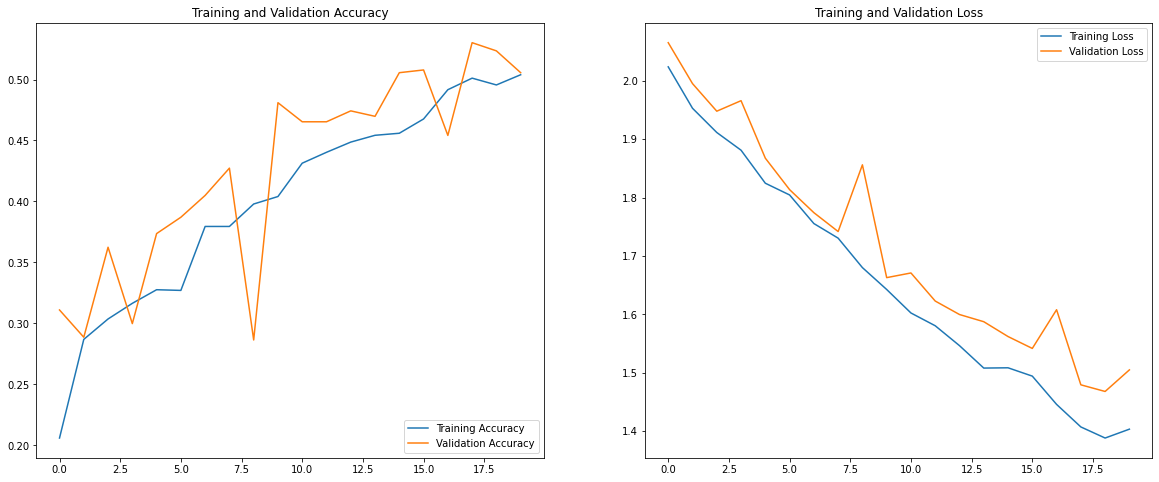

In [23]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Inference

> Thus you can see the model loss fluctuates. This is because the model doesn't have enough data to learn patterns in the image.



> You can see the loss curve for validation data at the last epochs is rising and hence it is a clear indication of overfitting.


> This is also because of class imbalance in the data.



> Lets take a look at the distribution of these classes and address class imbalance.









### Data distribution


> Lets take a look at bar plot for the classes we are dealing with


> This will help us better visualize the distribution of each class





<Figure size 720x720 with 0 Axes>

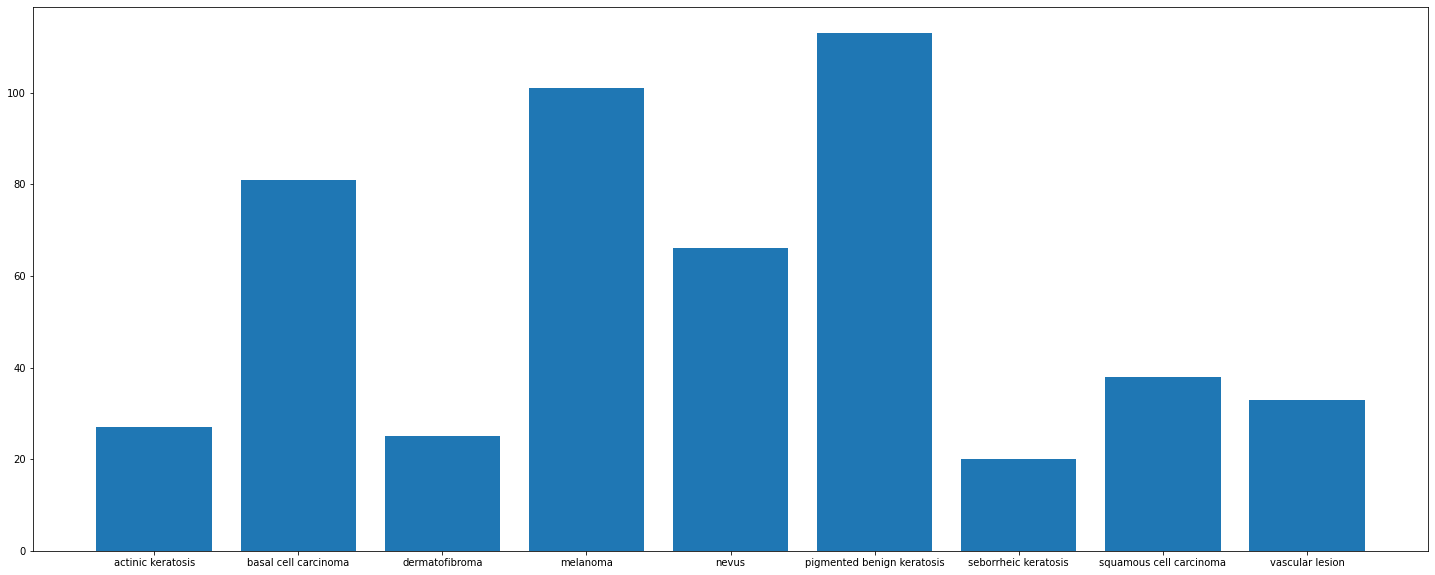

In [24]:
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(num_classes):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(25)
f.set_figheight(10)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

## Inference

> There is class imbalance and this might be the reason why our model wasn't accurate enough and was behaving eratic.


> Lets tackle this imbalance with the help of python package called augmentor

> As you can see most of the cases are from class pigmented benign keratosis and hence dominate the data in terms of the proportionate number of samples

> The next most number of cases are in melanoma and basal cell carcinoma respectively

> Seborrheic keratosis has the least number of samples and hence our model wouldn't be accurate in predicting this class










In [25]:
## Install augmentor
!pip install Augmentor

## To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F04267E2DD0>: 100%|██████████| 500/500 [00:18<00:00, 27.40 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F05340BC4D0>: 100%|██████████| 500/500 [00:18<00:00, 26.32 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F04940B3A90>: 100%|██████████| 500/500 [00:20<00:00, 23.93 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F0426740090>: 100%|██████████| 500/500 [01:42<00:00,  4.87 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F04903CF1D0>: 100%|██████████| 500/500 [01:21<00:00,  6.14 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F052B569450>: 100%|██████████| 500/500 [00:15<00:00, 31.39 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F04903CF110>: 100%|██████████| 500/500 [00:40<00:00, 12.45 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0490049710>: 100%|██████████| 500/500 [00:16<00:00, 31.17 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F04906C6310>: 100%|██████████| 500/500 [00:16<00:00, 30.17 Samples/s]


In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [28]:
import os
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]



In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [30]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))


In [31]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [32]:
new_df['Label'].value_counts()

vascular lesion               500
squamous cell carcinoma       500
seborrheic keratosis          500
nevus                         500
melanoma                      500
basal cell carcinoma          500
pigmented benign keratosis    500
actinic keratosis             500
dermatofibroma                500
Name: Label, dtype: int64

### Creating Dataset for Augmented dated



> Lets import the dataset again using the same procedure we used before



In [33]:
batch_size = 32
img_height = 180
img_width = 180


train_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, seed=123, subset='training',
                                                                 image_size=(img_height, img_width), validation_split=0.2,
                                                                  batch_size= batch_size)

val_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, seed=123, subset='validation',
                                                                 image_size=(img_height, img_width), validation_split=0.2,
                                                                 batch_size= batch_size)

test_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test, seed=123,
                                                                 image_size=(img_height, img_width),
                                                                 batch_size= batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.
Found 118 files belonging to 9 classes.


In [34]:
train_ds_transfer = train_ds_aug
val_ds_transfer = val_ds_aug

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


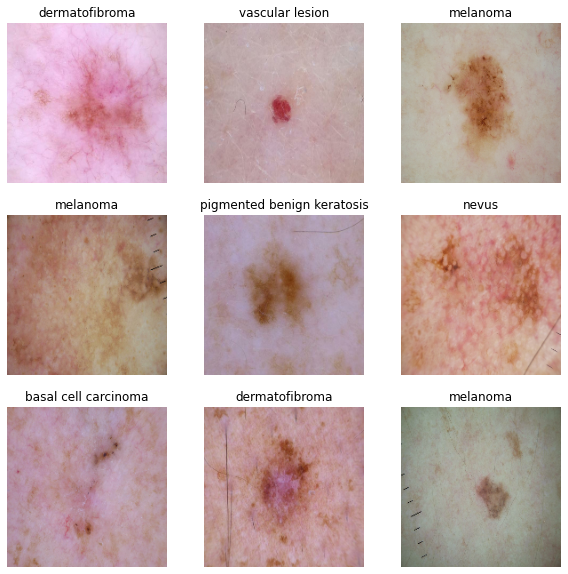

In [35]:
class_names = train_ds_aug.class_names
print(class_names)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds_aug.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [36]:
for image_batch, labels_batch in train_ds_aug:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


In [37]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_aug = train_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_aug = val_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)

### Model 3

> Lets run the same models we created earlier on the augmented data and see how augmentation improves the model



In [38]:
num_classes = len(class_names)

model_3 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(50, 1, activation='relu'),
  # tf.keras.layers.Dropout(0.1),
  tf.keras.layers.MaxPooling2D(4),
  tf.keras.layers.Conv2D(50, 1, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.MaxPooling2D(4),
  tf.keras.layers.Flatten(),
  # tf.keras.layers.Dense(50, activation='relu'),
  # tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [39]:
model_3.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [40]:

epochs=20
history_3 = model_3.fit(
  train_ds_aug,
  validation_data=val_ds_aug,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 36s 204ms/step - loss: 1.8898 - accuracy: 0.2927 - val_loss: 1.5861 - val_accuracy: 0.3979
Epoch 2/20
169/169 [==============================] - 5s 32ms/step - loss: 1.4606 - accuracy: 0.4564 - val_loss: 1.4310 - val_accuracy: 0.4833
Epoch 3/20
169/169 [==============================] - 5s 32ms/step - loss: 1.3338 - accuracy: 0.5147 - val_loss: 1.3586 - val_accuracy: 0.5137
Epoch 4/20
169/169 [==============================] - 5s 32ms/step - loss: 1.2412 - accuracy: 0.5530 - val_loss: 1.2876 - val_accuracy: 0.5412
Epoch 5/20
169/169 [==============================] - 5s 32ms/step - loss: 1.1618 - accuracy: 0.5849 - val_loss: 1.2272 - val_accuracy: 0.5590
Epoch 6/20
169/169 [==============================] - 5s 32ms/step - loss: 1.0897 - accuracy: 0.6159 - val_loss: 1.1733 - val_accuracy: 0.5843
Epoch 7/20
169/169 [==============================] - 5s 32ms/step - loss: 1.0228 - accuracy: 0.6417 - val_loss: 1.1258 - val_accuracy: 0.6058
Epoch 8/

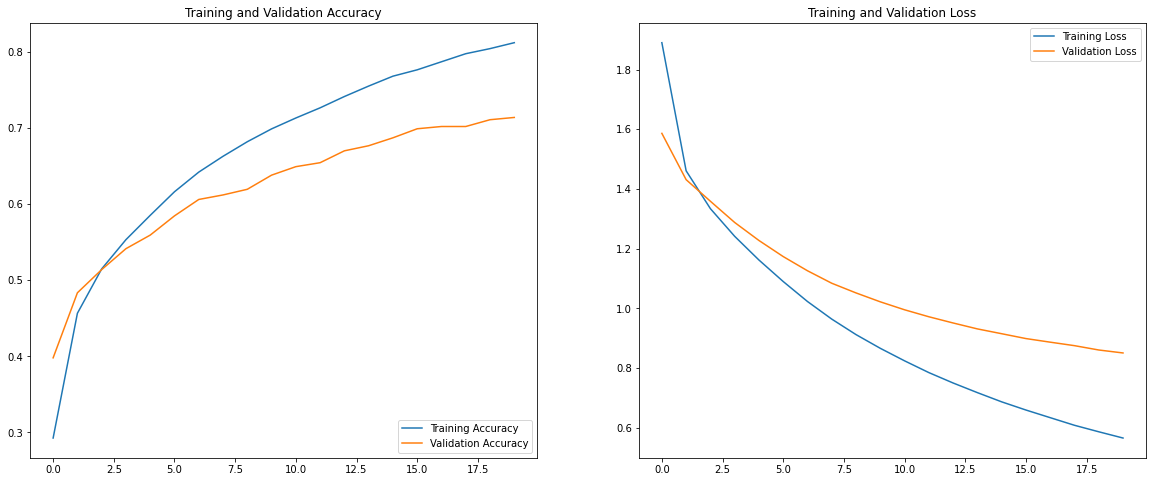

In [41]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Inference

> The model still overfits but has a better accuracy in validation as well as training.



> Since the model is very simple it doesn't do good learning of a significantly improved dataset

> Lets increase the complexity of the model by fitting a more complex model we defined earlier on this augmented data.







In [42]:
num_classes = len(class_names)

model_4 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(50, 3, activation='relu'),
  # tf.keras.layers.Dropout(0.1),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(50, 3, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(75, 3, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(50, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])



In [43]:
model_4.compile(
  tf.keras.optimizers.Adam(),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [44]:
epochs=20
history_4 = model_4.fit(
  train_ds_aug,
  validation_data=val_ds_aug,
  epochs=epochs)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 9s 49ms/step - loss: 2.0995 - accuracy: 0.1940 - val_loss: 1.9866 - val_accuracy: 0.3393
Epoch 2/20
169/169 [==============================] - 8s 45ms/step - loss: 1.7614 - accuracy: 0.3368 - val_loss: 1.7956 - val_accuracy: 0.4187
Epoch 3/20
169/169 [==============================] - 8s 46ms/step - loss: 1.6385 - accuracy: 0.3796 - val_loss: 1.6744 - val_accuracy: 0.4165
Epoch 4/20
169/169 [==============================] - 8s 46ms/step - loss: 1.5616 - accuracy: 0.4089 - val_loss: 1.6417 - val_accuracy: 0.4091
Epoch 5/20
169/169 [==============================] - 8s 45ms/step - loss: 1.5242 - accuracy: 0.4088 - val_loss: 1.5996 - val_accuracy: 0.4900
Epoch 6/20
169/169 [==============================] - 8s 46ms/step - loss: 1.4460 - accuracy: 0.4303 - val_loss: 1.5851 - val_accuracy: 0.4425
Epoch 7/20
169/169 [==============================] - 8s 46ms/step - loss: 1.3983 - accuracy: 0.4488 - val_loss: 1.4879 - val_accuracy: 0.4892
Epoch 8/20

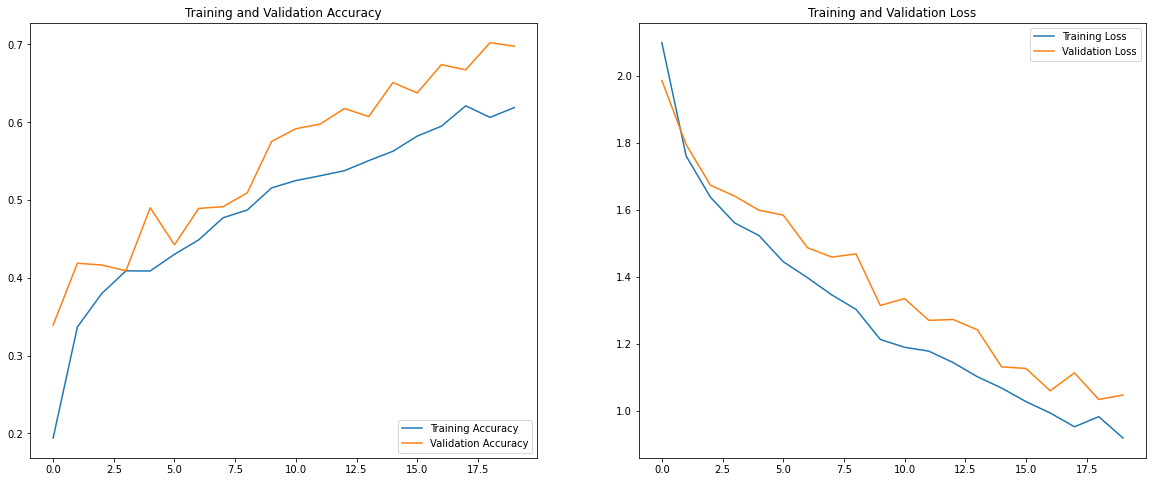

In [45]:
acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']

loss = history_4.history['loss']
val_loss = history_4.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Inference

> As you can see the model improves significantly and there is no overfitting since the model was able to train on sifficient data.


> Accuracy of the model can be further improved by increasing the epochs


> Thus trianing on small dataset often is computationally expensive



> We can get better results with the help of big pretained models, which can help increase accuracy significantly,










### Transfer Learning


> We will take the ResNet as the pretrained model and check if it increases accuracy





In [108]:
batch_size = 32
img_height = 180
img_width = 180

train_ds_transfer = ImageDataGenerator(preprocess_input, validation_split=0.2)
train_tds = train_ds_transfer.flow_from_directory(data_dir_train, seed=123, subset='training',
                                                 target_size =(img_height, img_width), class_mode='categorical',
                                                 batch_size= batch_size, shuffle=True)


val_ds_transfer = ImageDataGenerator(preprocess_input, validation_split=0.2)
val_tds = val_ds_transfer.flow_from_directory(data_dir_train, seed=123, subset='validation',
                                                 target_size =(img_height, img_width), class_mode='categorical',
                                                 batch_size= batch_size, shuffle=True)

# train_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input, validation_split=0.2)
# valid_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input, validation_split=0.2)
# train_data = train_data_gen.flow_from_directory(data_dir_train, (img_height,img_width), batch_size=batch_size, subset='training', class_mode='categorical', shuffle=True)
# valid_data = valid_data_gen.flow_from_directory(data_dir_train, (img_height,img_width), batch_size=batch_size, subset='validation', class_mode='categorical', shuffle= True)



Found 5395 images belonging to 9 classes.
Found 1344 images belonging to 9 classes.


In [114]:
def get_model():
  base_transfer_model = ResNet50(weights='imagenet', include_top=False)
  for layer in base_transfer_model.layers:
    layer.trainable = False

  base_transfer_model_output = base_transfer_model.output
  x = GlobalAveragePooling2D()(base_transfer_model_output)
  x = Dense(num_classes, activation='softmax')(x)
  model_resnet = Model(inputs=base_transfer_model.input, outputs = x)
  return model_resnet

In [115]:
model_res = get_model()

In [116]:
model_res.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])


In [117]:
model_res.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_9[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

In [118]:

history_5= model_res.fit(train_tds,epochs=5, steps_per_epoch = len(train_tds), validation_data=val_tds, validation_steps=len(val_tds))


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
169/169 [==============================] - 139s 443ms/step - loss: 1.6052 - accuracy: 0.4174 - val_loss: 1.3977 - val_accuracy: 0.4903
Epoch 2/5
169/169 [==============================] - 73s 435ms/step - loss: 1.2476 - accuracy: 0.5622 - val_loss: 1.2301 - val_accuracy: 0.5580
Epoch 3/5
169/169 [==============================] - 73s 434ms/step - loss: 1.1218 - accuracy: 0.6015 - val_loss: 1.1509 - val_accuracy: 0.5848
Epoch 4/5
169/169 [==============================] - 73s 435ms/step - loss: 1.0414 - accuracy: 0.6335 - val_loss: 1.1110 - val_accuracy: 0.5982
Epoch 5/5
169/169 [==============================] - 83s 489ms/step - loss: 0.9758 - accuracy: 0.6541 - val_loss: 1.0963 - val_accuracy: 0.5856


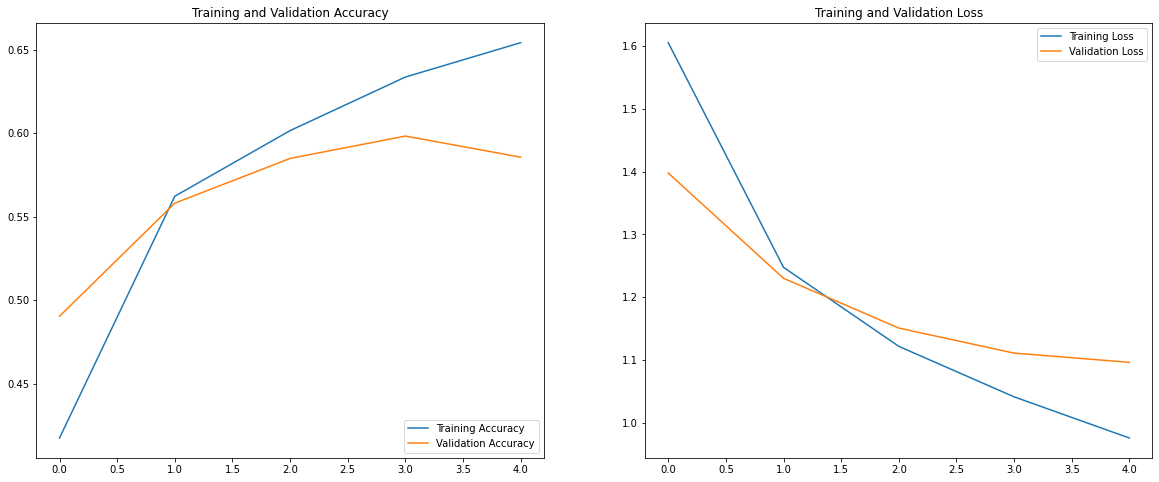

In [121]:
epochs = 5
acc = history_5.history['accuracy']
val_acc = history_5.history['val_accuracy']

loss = history_5.history['loss']
val_loss = history_5.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

With just 5 epochs it achieves a good accuracy. Though there is some overfitting, but this is mostly because the last few layers weren't trained for this problem set

Now lets train the last few layers of the model and see if we can improve on the accuracy.

In [122]:
for layer in model_res.layers[:125]: layer.trainable = False
for layer in model_res.layers[125:]: layer.trainable = True
sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_res.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
hist_6 = model_res.fit(train_tds,epochs=5, steps_per_epoch = len(train_tds),  validation_data=val_tds, validation_steps=len(val_tds))

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
169/169 [==============================] - 79s 444ms/step - loss: 0.8330 - accuracy: 0.7158 - val_loss: 0.6544 - val_accuracy: 0.7641
Epoch 2/10
169/169 [==============================] - 74s 440ms/step - loss: 0.3016 - accuracy: 0.9103 - val_loss: 0.5241 - val_accuracy: 0.8214
Epoch 3/10
169/169 [==============================] - 76s 449ms/step - loss: 0.1736 - accuracy: 0.9474 - val_loss: 0.4744 - val_accuracy: 0.8311
Epoch 4/10
169/169 [==============================] - 74s 437ms/step - loss: 0.1253 - accuracy: 0.9594 - val_loss: 0.5392 - val_accuracy: 0.8065
Epoch 5/10
169/169 [==============================] - 81s 479ms/step - loss: 0.1011 - accuracy: 0.9648 - val_loss: 0.5470 - val_accuracy: 0.8132
Epoch 6/10
169/169 [==============================] - 85s 505ms/step - loss: 0.0848 - accuracy: 0.9674 - val_loss: 0.5545 - val_accuracy: 0.8110
Epoch 7/10
169/169 [==============================] - 98s 576ms/step - loss: 0.0761 - accuracy: 0.9711 - val_loss: 0.6085 - val_ac

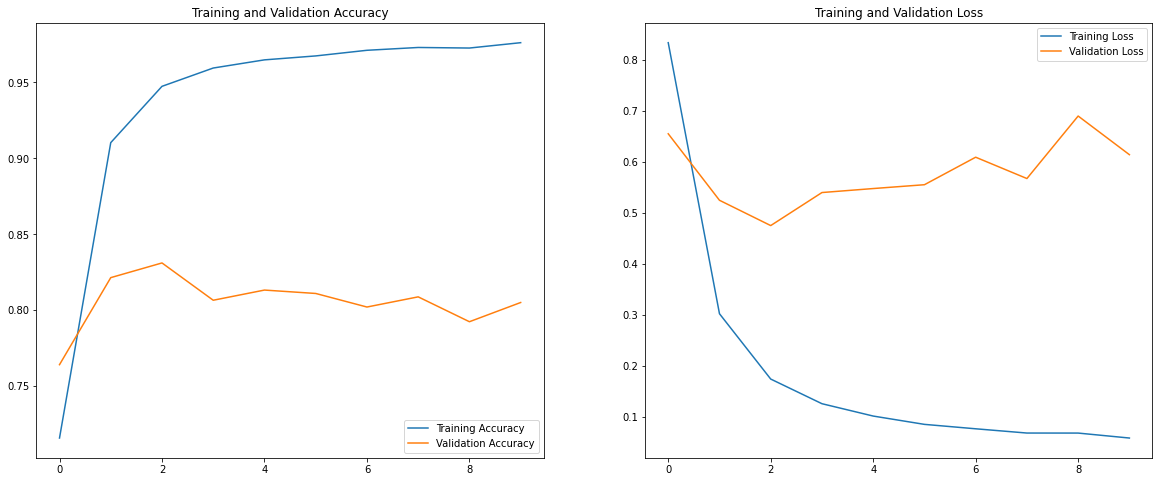

In [123]:
epochs = 10
acc = hist_6.history['accuracy']
val_acc = hist_6.history['val_accuracy']

loss = hist_6.history['loss']
val_loss = hist_6.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Lets implement PyTorch on the same probelm and see the difference.

> Transfer learning with PyTorch.

> We will use LeNet model





In [124]:
! pip3 install torch torchvision

In [138]:
import torchvision
import torch.utils.data as data
from torchvision import datasets, transforms, models
import torch
import numpy as np
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt

In [139]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [141]:
batch_size = 32
img_height = 180
img_width = 180

transform_train = transforms.Compose([transforms.ToTensor(),
                               transforms.Resize((img_height, img_width)),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.ImageFolder(root=data_dir_train, transform=transform_train)

train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size
train_dataset, validation_dataset = data.random_split(dataset, [train_size, validation_size])


train_data = torch.utils.data.DataLoader(dataset = train_dataset, batch_size= batch_size, shuffle =True)
validation_data = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size= batch_size, shuffle =True)



In [142]:
len(train_data), len(validation_data)

(169, 43)

In [143]:
trainSteps = len(train_data.dataset)
valSteps = len(validation_data.dataset)

In [144]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

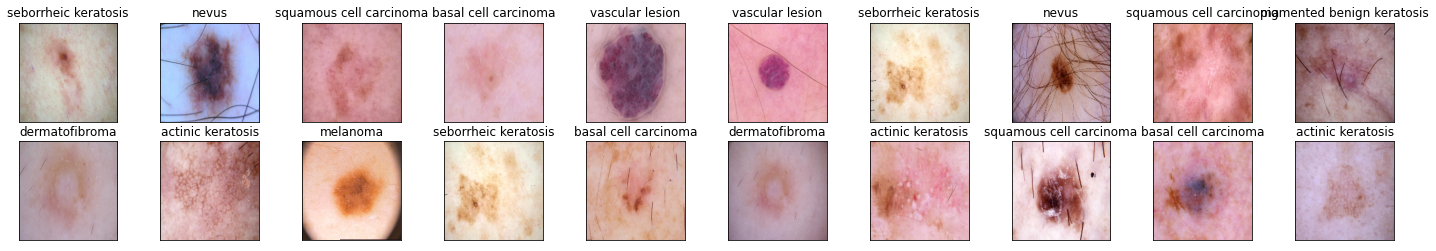

In [146]:
dataiter = iter(train_data)
images, labels = dataiter.next()
images_study = images
fig = plt.figure(figsize = (25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(class_names[labels[idx].item()])

In [147]:
images_study[1].shape

torch.Size([3, 180, 180])

In [148]:
torch_model = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [150]:
torch_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [151]:
#lets freeze the weights, so they dont get trained
for param in torch_model.features.parameters():
  param.requires_grad=False

In [152]:
import torch.nn as nn

In [154]:
n_inputs = torch_model.classifier[-1].in_features
last_layer = nn.Linear(n_inputs, num_classes)
torch_model.classifier[-1] = last_layer

In [155]:
torch_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [156]:
torch_model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [158]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(torch_model.parameters(), lr= 0.0001)

In [160]:
epochs = 10
running_loss_history = []
running_accuracy_history = []
validation_running_loss_history = []
validation_running_accuracy_history = []

for e in range(epochs):
  running_loss=0.
  running_accuracy = 0.
  validation_running_loss = 0.
  validation_running_accuracy = 0.
  for inputs, labels in train_data:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = torch_model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_loss +=loss.item()
    running_accuracy +=torch.sum(preds == labels.data)

  else:

    with torch.no_grad():
      for val_inputs, val_labels in validation_data:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = torch_model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        validation_running_loss +=val_loss.item()
        validation_running_accuracy += torch.sum(val_preds == val_labels.data)

    epoch_loss = running_loss/len(train_data.dataset)
    epoch_accuracy = running_accuracy.float()/len(train_data.dataset)
    running_loss_history.append(epoch_loss)
    running_accuracy_history.append(epoch_accuracy.cpu().detach().numpy())

    val_epoch_loss = validation_running_loss/len(validation_data.dataset)
    val_epoch_accuracy = validation_running_accuracy/len(validation_data.dataset)
    validation_running_loss_history.append(val_epoch_loss)
    validation_running_accuracy_history.append(val_epoch_accuracy.cpu().detach().numpy())

    print('epoch :', (e+1))
    print('training loss: {:.4f}, accuracy: {:.4f} '.format(epoch_loss, epoch_accuracy.item()))
    print('validation loss: {:.4f}, validation accuracy: {:.4f} '.format(val_epoch_loss, val_epoch_accuracy.item()))

epoch : 1
training loss: 0.0410, accuracy: 0.5251 
validation loss: 0.0340, validation accuracy: 0.6039 
epoch : 2
training loss: 0.0264, accuracy: 0.6958 
validation loss: 0.0276, validation accuracy: 0.6832 
epoch : 3
training loss: 0.0202, accuracy: 0.7692 
validation loss: 0.0238, validation accuracy: 0.7270 
epoch : 4
training loss: 0.0159, accuracy: 0.8149 
validation loss: 0.0217, validation accuracy: 0.7634 
epoch : 5
training loss: 0.0134, accuracy: 0.8479 
validation loss: 0.0191, validation accuracy: 0.7967 
epoch : 6
training loss: 0.0111, accuracy: 0.8752 
validation loss: 0.0190, validation accuracy: 0.8042 
epoch : 7
training loss: 0.0101, accuracy: 0.8855 
validation loss: 0.0187, validation accuracy: 0.8019 
epoch : 8
training loss: 0.0089, accuracy: 0.8945 
validation loss: 0.0176, validation accuracy: 0.8301 
epoch : 9
training loss: 0.0078, accuracy: 0.9097 
validation loss: 0.0167, validation accuracy: 0.8286 
epoch : 10
training loss: 0.0072, accuracy: 0.9123 
val

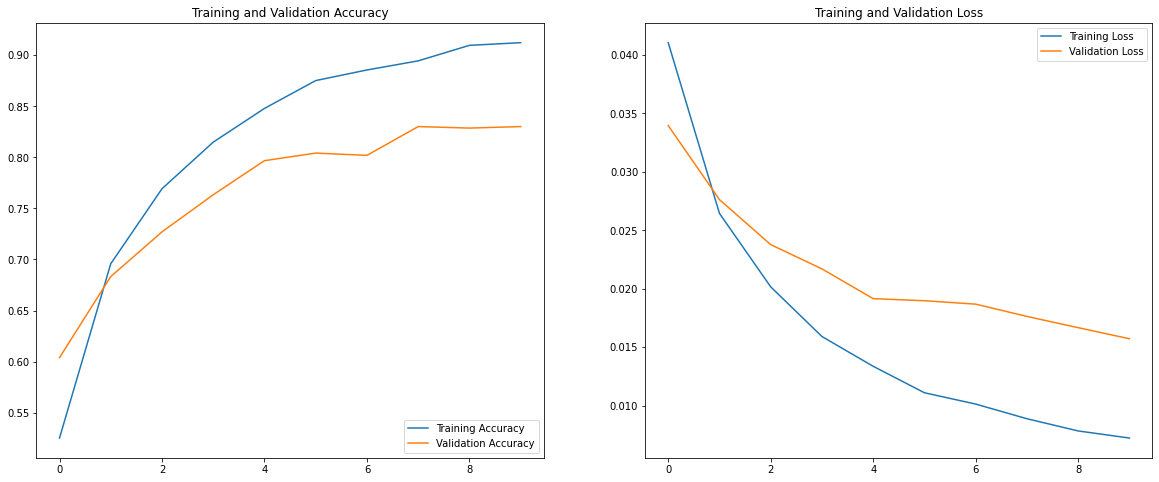

In [161]:
epochs_range = range(10)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, running_accuracy_history, label='Training Accuracy')
plt.plot(epochs_range, validation_running_accuracy_history, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, running_loss_history, label='Training Loss')
plt.plot(epochs_range, validation_running_loss_history, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

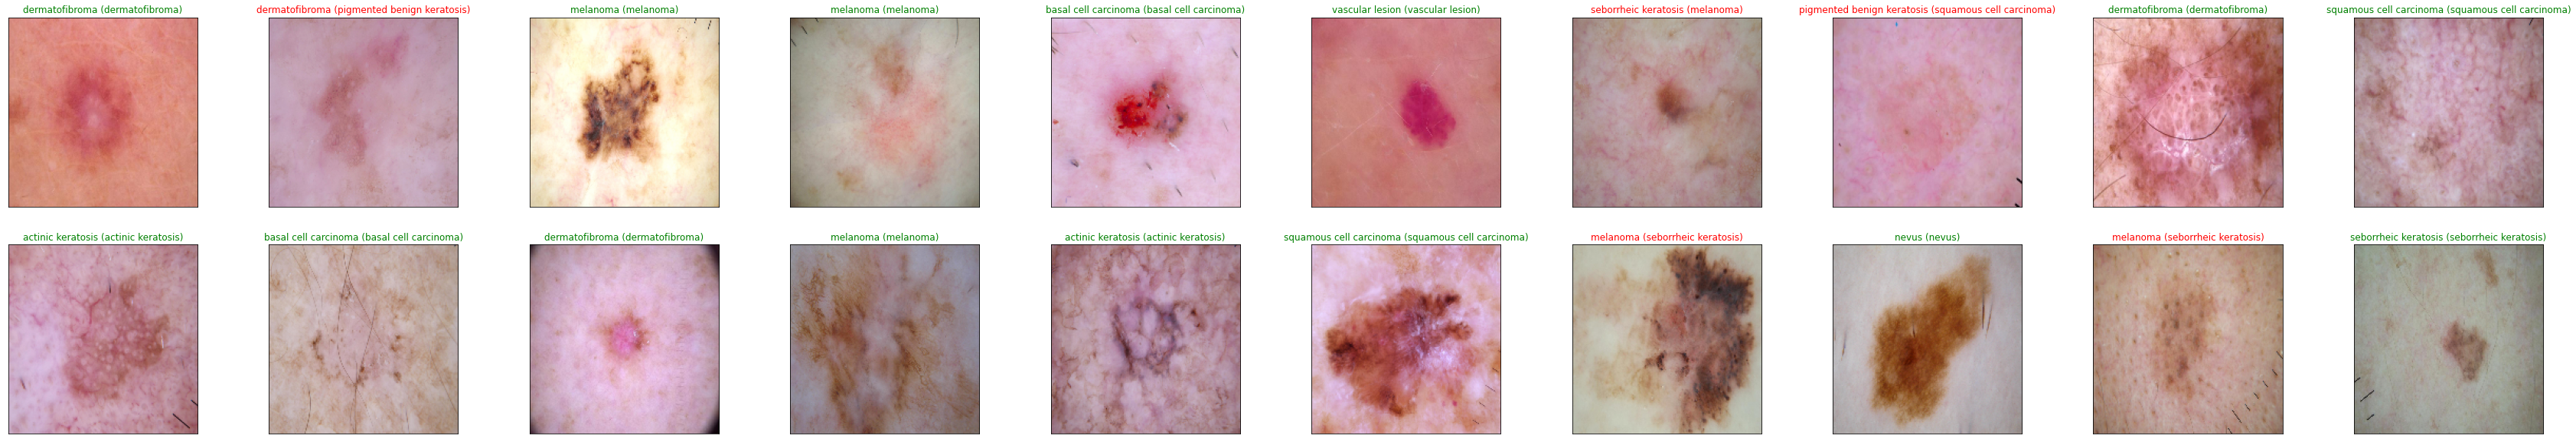

In [167]:
dataiter = iter(validation_data)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = torch_model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(60, 10))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(class_names[preds[idx].item()]), str(class_names[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))




1.  Data Reading/Data Understanding

*   Defined the path for train dataset and imported data from folder
*   Defined the path for test dataset and imported data from folder



---


2.   Dataset creation

*   Created train & validation dataset from the train directory with a batch size of 32 
*   Resized images to 180*180.

---



3.   Dataset visualisation

*   Created a code to visualize one instance of all the nine classes present in the dataset 
*   Created a code to randomly visualize 20 images in a batch in PyTorch




---




4.   Model Building & training

*   Created a CNN model, which can accurately detect 9 classes present in the dataset.
*   Defined appropriate optimiser and loss function for model training.


*   Trained the model for 20 epochs.
*   Explained the findings after the model fit with evidence if the earlier issue is resolved or not.



---




5.   Class distribution

*    Examined the current class distribution in the training dataset & explained which class dominate the data in terms of the proportionate number of samples

*   Pointed out the class that has least number of samples

---




6.   Handling class imbalances


*   Rectified class imbalances present in the training dataset with Augmentor library

---



7.   Model Building & training after Augmentation

*   Built two models after augmentation 
*   Explained that because of high number of samples and balance in class, the models had higher accuracy than imbalanced data, also was less overfitting

---


8.   Transfer learning model

*  Imported resnet model and trained it with data, changed last layer output feature
*  Trained resnet model by training the last few layers of it along with our output layer

---


9.   PyTorch model with transfer learning
*    Imported Alexnet model and called it to fit our data, changed the last layer to represent our output classes.
*   Randomly plotted 20 images in the test validation data set to test how our model was doing


---












